# Using real world data and CNN layer

This time I will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

Let's get started!

In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should omit the first line as the file contains headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the temperature can be accessed via row[1] and the date can be discarded.
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. You can use Python's built-in `float` function to ensure this.

In [ ]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:

        ### START CODE HERE
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for row in reader:
            temperature = float(row[1])
            temperatures.append(temperature)

        for i in range(len(temperatures)):
            times.append(i)

        ### END CODE HERE

    return times, temperatures

The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

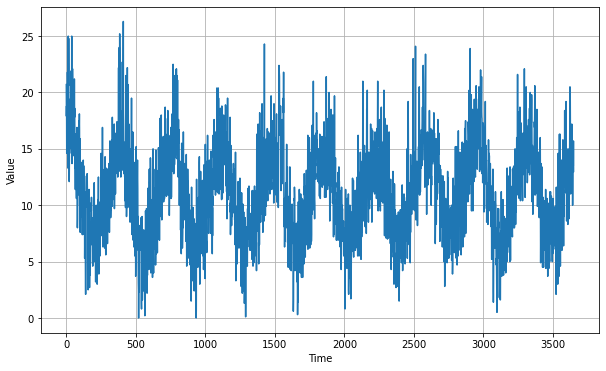

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [ ]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                               padding='causal',strides=1,
                               activation='relu',input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*400.0)

    ])

    return model

In [ ]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate

In [ ]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=[["mae","mse"]])

    history = model.fit(dataset, epochs=30, callbacks=[lr_schedule])

    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/30
77/77 [==============================] - 29s 294ms/step - loss: 3.1477 - mae: 3.6120 - mse: 24.5348 - lr: 1.0000e-04
Epoch 2/30
77/77 [==============================] - 22s 286ms/step - loss: 2.1493 - mae: 2.6059 - mse: 10.7868 - lr: 1.1220e-04
Epoch 3/30
77/77 [==============================] - 23s 295ms/step - loss: 2.0252 - mae: 2.4795 - mse: 10.0000 - lr: 1.2589e-04
Epoch 4/30
77/77 [==============================] - 22s 288ms/step - loss: 1.9382 - mae: 2.3930 - mse: 9.2038 - lr: 1.4125e-04
Epoch 5/30
77/77 [==============================] - 23s 295ms/step - loss: 1.7651 - mae: 2.2172 - mse: 7.8791 - lr: 1.5849e-04
Epoch 6/30
77/77 [==============================] - 21s 275ms/step - loss: 1.8446 - mae: 2.2971 - mse: 8.5658 - lr: 1.7783e-04
Epoch 7/30
77/77 [==============================] - 20s 260ms/step - loss: 2.1483 - mae: 2.6052 - mse: 10.8319 - lr: 1.9953e-04
Epoch 8/30
77/77 [==============================] - 20s 258ms/step - loss: 1.9614 - mae: 2.4180 - mse: 9.37

(0.0001, 10.0, 0.0, 10.0)

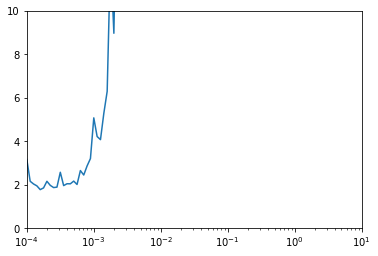

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model

In [ ]:
def create_model():
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
                  metrics=[["mae","mse"]])
    return model

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 13s 124ms/step - loss: 5.9745 - mae: 6.4376 - mse: 256.2218
Epoch 2/50
77/77 [==============================] - 10s 124ms/step - loss: 1.8336 - mae: 2.2883 - mse: 8.4706
Epoch 3/50
77/77 [==============================] - 9s 118ms/step - loss: 1.8388 - mae: 2.2921 - mse: 8.4305
Epoch 4/50
77/77 [==============================] - 9s 117ms/step - loss: 1.7855 - mae: 2.2377 - mse: 8.2109
Epoch 5/50
77/77 [==============================] - 9s 120ms/step - loss: 1.7945 - mae: 2.2464 - mse: 8.1842
Epoch 6/50
77/77 [==============================] - 9s 122ms/step - loss: 1.7284 - mae: 2.1819 - mse: 7.6607
Epoch 7/50
77/77 [==============================] - 10s 125ms/step - loss: 1.7713 - mae: 2.2250 - mse: 7.9280
Epoch 8/50
77/77 [==============================] - 10s 124ms/step - loss: 1.6577 - mae: 2.1043 - mse: 7.2939
Epoch 9/50
77/77 [==============================] - 10s 125ms/step - loss: 1.7366 - mae: 2.1878 - mse: 7.6551
Epoch 10/50


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

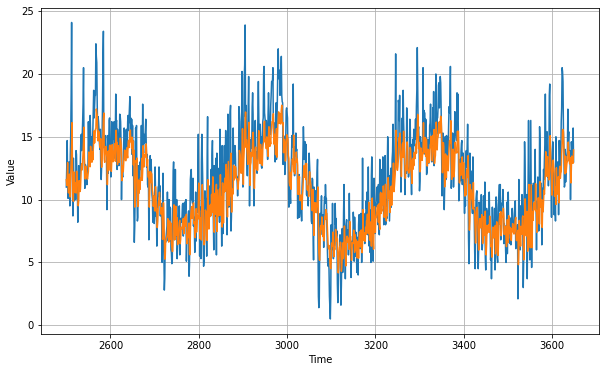

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 6.00, mae: 1.92 for forecast


In [ ]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
